## Importing Libraries and upload our text file

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os
from google.colab import files
uploaded = files.upload()

Saving Romio & Juliet.txt to Romio & Juliet.txt


## Pre-processing the data

In [2]:
file = open("Romio & Juliet.txt", "r", encoding = "utf8")

In [3]:
# store file in list
lines = []
for i in file:
    lines.append(i)

This iterates each line in the file and stores it in a list

In [4]:
# Convert list to string
data = ""
for i in lines:
  data = ' '. join(lines) 

In [5]:
#replace unnecessary stuff with space
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('“','').replace('”','')  
#new line, carriage return, unicode character --> replace by space

In [6]:
#remove unnecessary spaces 
data = data.split()
data = ' '.join(data)

In [7]:
data[:500]

'The Project Gutenberg eBook of Romeo and Juliet, by William Shakespeare This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org. If you are not located in the United States, you will have to check the laws of the country where you are located before usi'

In [8]:
len(data)

160221

### Tokenization

We don't use tokenizer from NLTK but from Tensorflow.keras because it provides us the ease to convert string to sequence and sequence to text, which we will use later.

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

In [10]:
# Saving my tokenizer file using pickle
# We will need it in the prediction function

pickle.dump(tokenizer, open('token.pkl', 'wb'))

In [11]:
# We need to convert our string or text data into some numeric representation.
sequence_data = tokenizer.texts_to_sequences([data])[0]

In [12]:
sequence_data[:15]

[1, 53, 49, 306, 6, 12, 2, 22, 32, 967, 783, 16, 306, 8, 18]

The above function provides each unique element a numeric representation, hence when we find length below, it is less than the actual number of words in our data.

Also, it filters out punctuations.

In [13]:
len(sequence_data), type(sequence_data)

(29352, list)

In [14]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

4282


An index of 0 is usually reserved for padding, which is used to make all sequences of words the same length.

When padding is used, the input sequences are padded with zeros (or other values) to ensure they have the same length. This is necessary because machine learning models typically require inputs of fixed size. By reserving index 0 for padding, we ensure that it is not assigned to any actual word in the text.

In [15]:
sequences = []

for i in range(3, len(sequence_data)):
    words = sequence_data[i-3:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))

The Length of sequences are:  29349


The '3' in the above code is the number of words i am using to predict the next word.

In the above code, we insert four words in the list at a time.

Out of these, the first three will be the input and last will be the output.

In [16]:
sequences = np.array(sequences)
sequences[:10]

array([[  1,  53,  49, 306],
       [ 53,  49, 306,   6],
       [ 49, 306,   6,  12],
       [306,   6,  12,   2],
       [  6,  12,   2,  22],
       [ 12,   2,  22,  32],
       [  2,  22,  32, 967],
       [ 22,  32, 967, 783],
       [ 32, 967, 783,  16],
       [967, 783,  16, 306]])

Now, we will seperate our input and output:

In [17]:
X = []
y = []

In [18]:
for i in sequences:
    X.append(i[0:3])
    y.append(i[3])

In [19]:
X = np.array(X)
y = np.array(y)

In [20]:
X.shape, y.shape

((29349, 3), (29349,))

In [21]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

The code snippet y = to_categorical(y, num_classes=vocab_size) converts y into a binary class matrix with vocab_size columns, where each row has a 1 in the column corresponding to the index of the correct next word and 0 in all other columns.

This is necessary because the LSTM network is trained to output a probability distribution over all words in the vocabulary for the next word prediction task. The binary class matrix representation allows the network to compute the loss and optimize the model parameters using backpropagation during training.

## Creating the model

In [22]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

We use "return_sequences=True" when we intend to create another LSTM layer in continuation.

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             42820     
                                                                 
 lstm (LSTM)                 (None, 3, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 4282)              4286282   
                                                                 
Total params: 17,378,102
Trainable params: 17,378,102
Non-trainable params: 0
_________________________________________________________________


## Ploting the model

In [24]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

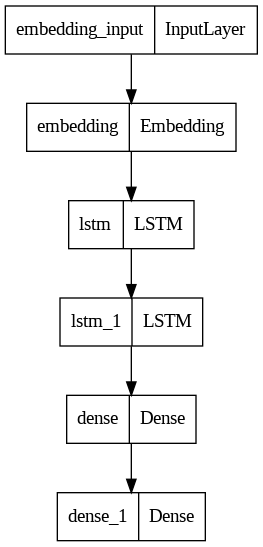

In [25]:
keras.utils.plot_model(model, to_file='plot.png', show_layer_names=True)

## Training our model

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [27]:
checkpoint = ModelCheckpoint("next_words.h5", monitor='loss', verbose=1, save_best_only=True)

The ModelCheckpoint callback is used to save the model weights at certain intervals during training, which can be useful for resuming training if interrupted or for selecting the best model based on a validation metric. In this case, the callback is configured to save the model weights to a file named "next_words.h5", monitor the training loss, display verbose output, and save only the weights that result in the best loss value.

In [28]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001))

In [30]:
model.fit(X, y, epochs=80, batch_size=64, callbacks=[checkpoint])

Epoch 1/80
456/459 [============================>.] - ETA: 0s - loss: 0.1974
Epoch 1: loss improved from 0.21820 to 0.19826, saving model to next_words.h5
459/459 [==============================] - 7s 15ms/step - loss: 0.1983
Epoch 2/80
459/459 [==============================] - ETA: 0s - loss: 0.1964
Epoch 2: loss improved from 0.19826 to 0.19637, saving model to next_words.h5
459/459 [==============================] - 7s 15ms/step - loss: 0.1964
Epoch 3/80
458/459 [============================>.] - ETA: 0s - loss: 0.2070
Epoch 3: loss did not improve from 0.19637
459/459 [==============================] - 6s 14ms/step - loss: 0.2072
Epoch 4/80
456/459 [============================>.] - ETA: 0s - loss: 0.2452
Epoch 4: loss did not improve from 0.19637
459/459 [==============================] - 7s 16ms/step - loss: 0.2453
Epoch 5/80
457/459 [============================>.] - ETA: 0s - loss: 0.2449
Epoch 5: loss did not improve from 0.19637
459/459 [==============================] - 6s 

## Prediction

In [31]:
from tensorflow.keras.models import load_model
import numpy as np
import pickle

In [32]:
# Load the model and tokenizer
model = load_model('next_words.h5')
tokenizer = pickle.load(open('token.pkl', 'rb'))

In [33]:
def Predict_Next_Words(model, tokenizer, text):

  sequence = tokenizer.texts_to_sequences([text])
  sequence = np.array(sequence)
  preds = np.argmax(model.predict(sequence))
  predicted_word = ""
  
  for key, value in tokenizer.word_index.items():
      if value == preds:
          predicted_word = key
          break
  
  print(predicted_word)
  return predicted_word

In [34]:
while(True):
  text = input("Enter your line: ")
  
  if text == "0":
      print("Execution completed.....")
      break
  
  else:
      try:
          text = text.split(" ")
          text = text[-3:]
          print(text)
        
          Predict_Next_Words(model, tokenizer, text)
          
      except Exception as e:
        print("Error occurred: ",e)
        continue

Enter your line: are you the
['are', 'you', 'the']
1/1 [==============================] - 1s 680ms/step
lark
Enter your line: Can you please
['Can', 'you', 'please']
1/1 [==============================] - 0s 19ms/step
see
Enter your line: I definitly mean
['I', 'definitly', 'mean']
1/1 [==============================] - 1s 608ms/step
to
Enter your line: romeo fo not
['romeo', 'fo', 'not']
1/1 [==============================] - 0s 24ms/step
i
Enter your line: romeo do not
['romeo', 'do', 'not']
1/1 [==============================] - 0s 27ms/step
know
Enter your line: do not know
['do', 'not', 'know']
1/1 [==============================] - 0s 27ms/step
the
Enter your line: not know thw
['not', 'know', 'thw']
1/1 [==============================] - 0s 27ms/step
the
Enter your line: not know the
['not', 'know', 'the']
1/1 [==============================] - 0s 18ms/step
lady’s
Enter your line: know thw lady's
['know', 'thw', "lady's"]
1/1 [==============================] - 0s 20ms/step
it
En